1. Zjistit jak jsem modifikoval
2. Popisná satistika - sloupců
3. Vzít si baseline model, vzít si skupinu modelů (klasifikace, regrese), Tunning, Report (výstupy metrik)
4. Čas pro naučení
5. Porovnání modelů (který např selže, provést analýzu na poruchových vzorcích, jaký je rozdíl mezi nimi)
6. Umět to vysvětlit, rozumět tomu

### Analýza datasetu

Zobrazení kořenové struktury datasetu.

In [35]:
from pathlib import Path

space =  '    '; branch = '│   '; tee =    '├── '; last =   '└── '
def tree(dir_path: Path, prefix: str='', exclude_extensions=None):
    if exclude_extensions is None: exclude_extensions = ['.jpg']
    if isinstance(dir_path, str): dir_path = Path(dir_path)
    # Filter out files with excluded extensions
    contents = [p for p in dir_path.iterdir()  if not (p.is_file() and p.suffix.lower() in exclude_extensions)]
    if not contents: return
    # contents each get pointers that are ├── with a final └── :
    pointers = [tee] * (len(contents) - 1) + [last]
    for pointer, path in zip(pointers, contents):
        yield prefix + pointer + path.name
        if path.is_dir():  # extend the prefix and recurse:
            extension = branch if pointer == tee else space
            # i.e. space because last, └── , above so no more |
            yield from tree(path, prefix=prefix+extension, exclude_extensions=exclude_extensions)

for line in tree('./nikitarom'):
    print(line)

└── planets-dataset
    ├── 3.complete
    └── versions
        └── 3
            ├── planet
            │   └── planet
            │       ├── sample_submission.csv
            │       ├── test-jpg
            │       ├── train-jpg
            │       └── train_classes.csv
            └── test-jpg-additional
                └── test-jpg-additional


První csv tabulka s názvem **sample_submission.csv** obsahuje 61191 hodnot, obsahuje 2 sloupce: image_name - název daného obrázku tags - popis vlastností toho co je na obrázcích.

Druhá csv tabulka s názvem **train_classes.csv** obsahuje 40 479 hodnot obsahuje také 2 sloupce: image_name - název daného obrázku tags - popis vlastností toho co je na obrázcích např.: clear_primary, clear_cloudy_primary, atd...

Máme adresáře pro obrázky:

**test-jpg**, kde se nachází testovací obrázky, je jich přibližně 40 000.

**train-jpg**, kde se nachází trénovací obrázky, je jich přibližně 40 000.

**test-jpg-additional**, kde se nachází testovací ještě nachází přibližně 20 500 testovacích obrázků navíc.



### Načtení dat pro trénovací model

In [47]:
#import potřebných datasetů
import os
import pandas as pd
import numpy as np
import seaborn as sns
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, multilabel_confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Nastavení cest k datům
DATA_DIR = './nikitarom/planets-dataset/versions/3/'
TRAIN_DIR = os.path.join(DATA_DIR, 'planet/planet/train-jpg')
TEST_DIR = os.path.join(DATA_DIR, 'planet/planet/test-jpg')
TRAIN_CLASSES = os.path.join(DATA_DIR, 'planet/planet/train_classes.csv')
SUBMISSION = os.path.join(DATA_DIR, 'planet/planet/sample_submission.csv')

# Načtení CSV souborů
train_df = pd.read_csv(TRAIN_CLASSES)
submission_df = pd.read_csv(SUBMISSION)


Naimportoval jsem potřebné datasety pro práci s daty. Určil jsem si cesty k adresářům s trénovací a testovacími obrázky a s popisem obrázků. Načetl jsem si csv soubory.

#### Zjišťovaní informací o tabulce

In [48]:
print(f"Počet trénovacích záznamů: {len(train_df)}")
print(f"Počet testovacích záznamů: {len(submission_df)}")

# Zobrazení informací o tabulce
print('\nZobrazení informací o trénovací tabulce:')
print("Hlavička tabulky: \n", train_df.head(), '\n')
print("Informace o tabulce: ", train_df.info(), '\n')
print("Nulové hodnoty: ", train_df.isnull().sum(), '\n')

# Zobrazme si distribuci tagů ve sloupci 'tags'
all_tags = []
for tags in train_df['tags'].values:
    all_tags.extend(tags.split())
unique_tags = sorted(list(set(all_tags)))
print(f"\nPočet unikátních tagů: {len(unique_tags)}")
print(f"Unikátní tagy: {unique_tags}")


Počet trénovacích záznamů: 40479
Počet testovacích záznamů: 61191

Zobrazení informací o trénovací tabulce:
Hlavička tabulky: 
   image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  40479 non-null  object
 1   tags        40479 non-null  object
dtypes: object(2)
memory usage: 632.6+ KB
Informace o tabulce:  None 

Nulové hodnoty:  image_name    0
tags          0
dtype: int64 


Počet unikátních tagů: 17
Unikátní tagy: ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloud

Vypsal jsem si informace o tabulce, abych věděl kolik s ní je záznamů, jak má nastavené sloupce, jestli tam například jsou povoleny nulové hodnoty a jakého typu jsou. Také jsem si vypsal informace o tom, jestli obsahuje nějaké nulové hodnoty a kolik je tagů ve sloupci *tags*, kde jsem zjistil, že se vyskytuje 17 různých tagů pro popis obrázků.

Unikátní tagy:

agriculture, artisinal_mine, bare_ground, blooming, blow_down, clear, cloudy, conventional_mine, cultivation, habitation, haze, partly_cloudy, primary, road, selective_logging, slash_burn, water

In [49]:
# Zobrazení informací o testovací tabulce
print('\nZobrazení informací o testovací tabulce:')
print("Hlavička tabulky: \n", submission_df.head(), '\n')
print("Informace o tabulce: ", submission_df.info(), '\n')
print("Nulové hodnoty: ", submission_df.isnull().sum(), '\n')

test_all_tags = []
for tags_str in submission_df["tags"].values:
    test_all_tags.extend(tags_str.split())
test_unique_tags = sorted(list(set(test_all_tags)))
print(f"\nPočet tagů v testovacích datech: {len(test_unique_tags)}")
print(f"Tagy: {test_unique_tags}")


Zobrazení informací o testovací tabulce:
Hlavička tabulky: 
   image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61191 entries, 0 to 61190
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  61191 non-null  object
 1   tags        61191 non-null  object
dtypes: object(2)
memory usage: 956.2+ KB
Informace o tabulce:  None 

Nulové hodnoty:  image_name    0
tags          0
dtype: int64 


Počet tagů v testovacích datech: 5
Tagy: ['agriculture', 'clear', 'primary', 'road', 'water']


Zobrazení informací o testovací tabulce. Zde je v informacích o tabulce vidět, že testovací tabulka nemá rozdělené tagy a v každém sloupci je napsáno 5 možných tagů.

#### Analýza frekvence tagů
Abych měl přehled o tom kolikrát se který tag v trénovací tabulce vyskytuje.


Nejčastější tagy:
primary: 37513 výskytů
clear: 28431 výskytů
agriculture: 12315 výskytů
road: 8071 výskytů
water: 7411 výskytů
partly_cloudy: 7261 výskytů
cultivation: 4547 výskytů
habitation: 3660 výskytů
haze: 2697 výskytů
cloudy: 2089 výskytů


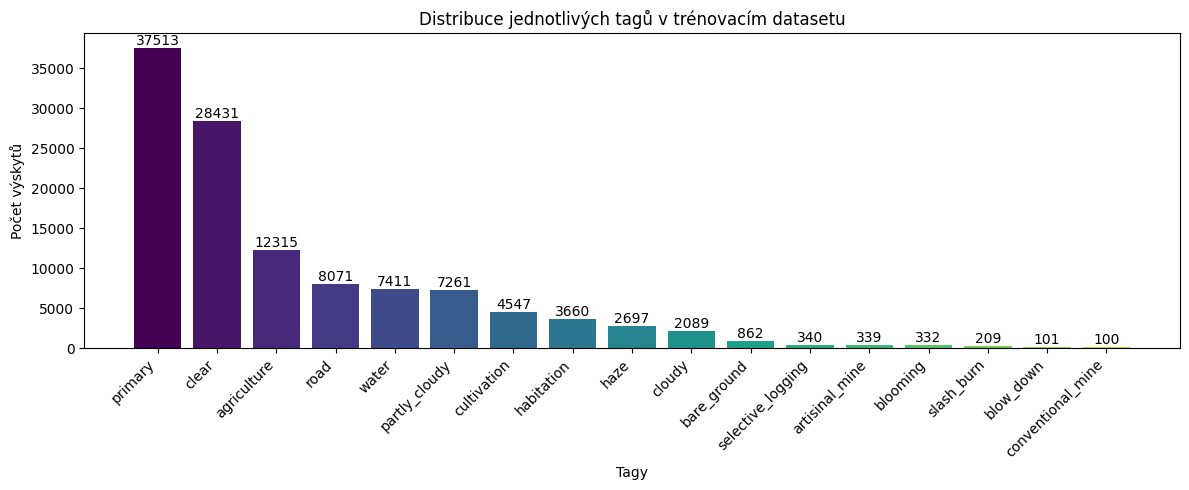

In [50]:
tag_counts = {}
for tag in all_tags:
    if tag in tag_counts: tag_counts[tag] += 1
    else: tag_counts[tag] = 1

sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
print("\nNejčastější tagy:")
for tag, count in sorted_tags[:10]:
    print(f"{tag}: {count} výskytů")

def plot_tag_distribution(sorted_tags):
    tags = [tag for tag, _ in sorted_tags]
    counts = [count for _, count in sorted_tags]
    plt.figure(figsize=(12, 5))
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(tags)))
    bars = plt.bar(range(len(tags)), counts, color=colors)
    plt.xlabel('Tagy'); plt.ylabel('Počet výskytů'); plt.title('Distribuce jednotlivých tagů v trénovacím datasetu')
    plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{int(height)}', ha='center', va='bottom')
    plt.tight_layout(); plt.savefig('tags_distribution_train.png'); plt.show(); plt.close()

plot_tag_distribution(sorted_tags)

### Trénování dat a vytvoření klasifikátorů

#### Vytvoření one-hot encodingu pro tagy
Abych mohl s tagy u obrázků trénovacím modelu pracovat, tak si musím data převét na vektory, abych s nimi mohl pracovat v PyTorch, kde je poté pomocí tensoru převeden na formát vektorů ve floatech, s kterým bude pracovat trénovací model. Vypíšem si hlavičku datasetu a je tam vidět nový vytvořený sloupec, kde u každého záznamu je udělaný vektor pole, který má 17 hodnot ve formátu floatu, které buďto reprezentují 1.0(True) a nebo 0.0(False) hodnotu, podle toho jestli dané tagy obrázek obsahuje. Jeden obrázek může mít víc tagů.

In [51]:
# Vytvoření one-hot encodingu pro tagy
def get_tag_map(tags):
    labels = np.zeros(len(unique_tags))
    if pd.isna(tags): return labels
    for tag in tags.split():
        if tag in unique_tags:
            labels[unique_tags.index(tag)] = 1
    return labels
# Přidání one-hot encodingu do dataframe
train_df['tag_vector'] = train_df['tags'].apply(get_tag_map)
print(train_df.head())

  image_name                                       tags  \
0    train_0                               haze primary   
1    train_1            agriculture clear primary water   
2    train_2                              clear primary   
3    train_3                              clear primary   
4    train_4  agriculture clear habitation primary road   

                                          tag_vector  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  


#### Vytvoření dataset třídy pro PyTorch DataLoader
Abych mohl trénovat data v Resnet50, tak si musím vytvořit dataset třídu pro PyTorch. V této třídě si určím dataframe, s kterým budu pracovat, adresář pro obrázky a typ transformace pro dané obrázky. Je tu funkce, která mi vrací délku dataframu a funkce __getitem__, která načte obrázky, aplikuje na ně transformaci. Pomocí FloatTensor v PyTorch převede pro sloupec tag_vector obsahující vektory tagů, převede vektory tagů ve floatu do multi-dimensionální matice obsahující elementy daného datového typu k trénování datasetu a potom vrátíme vytvořený dataset pro zpracování s obrázky a tag vektorem.

In [52]:
# Vytvoření vlastní Dataset třídy pro PyTorch
class PlanetDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        # Načtení obrázku
        image = Image.open(img_path).convert('RGB')
        # Aplikace transformací, pokud jsou definované
        if self.transform: image = self.transform(image)
        # Získání one-hot encodingu pro tagy
        tag_vector = torch.FloatTensor(self.dataframe.iloc[idx]['tag_vector'])
        return image, tag_vector

#### Definování transformace
Nadefinujem si transformaci pro trénovací a validační data, která bude použita pro trénování modelu. Můžem si nadefinovat zvlášť transformaci pro trénovací data a pro validační data.

U transformace si můžeme určit.:
- U jaké velikosti v pixelech chceme začít.
- Jestli je převedeme na tensor.
- Jestli chceme obrázek náhodně otáčet horizontálně nebo vertikálně. Tohle se hodně hodí pro obrázky tohoto typu, protože dané obrázky mohou být jakkoliv vyfoceny. 
- Náhodnou rotaci, u které si určíme počet stupňů.
- Můžem si upravit obraz, jaký chceme mít jas, kontrast, sytost, a další...
- Normalizaci dat, kde určíme průměr a směrodatnou odchylku na třídimenzionální data transformovaní obrázků.
- A spoustu dalších vlastností...

In [53]:
# Definování transformací pro obrázky
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Rozdělení na trénovací data a jejich připracení pro trénování modelu
Model si rozdělím na trénovací a validační data. Nastavím si rozdělení trénovacích dat a validačních dat 80/20 a random_state pro zamíchání dat. Následně si vypíši kolik tam je trénovacích a validačních vzorků Vytvořím si datasety pro trénovací a validační data podle třídy PlanetDataset definované pro train model pomocí torch. 


Počet trénovacích vzorků: 32383
Počet validačních vzorků: 8096


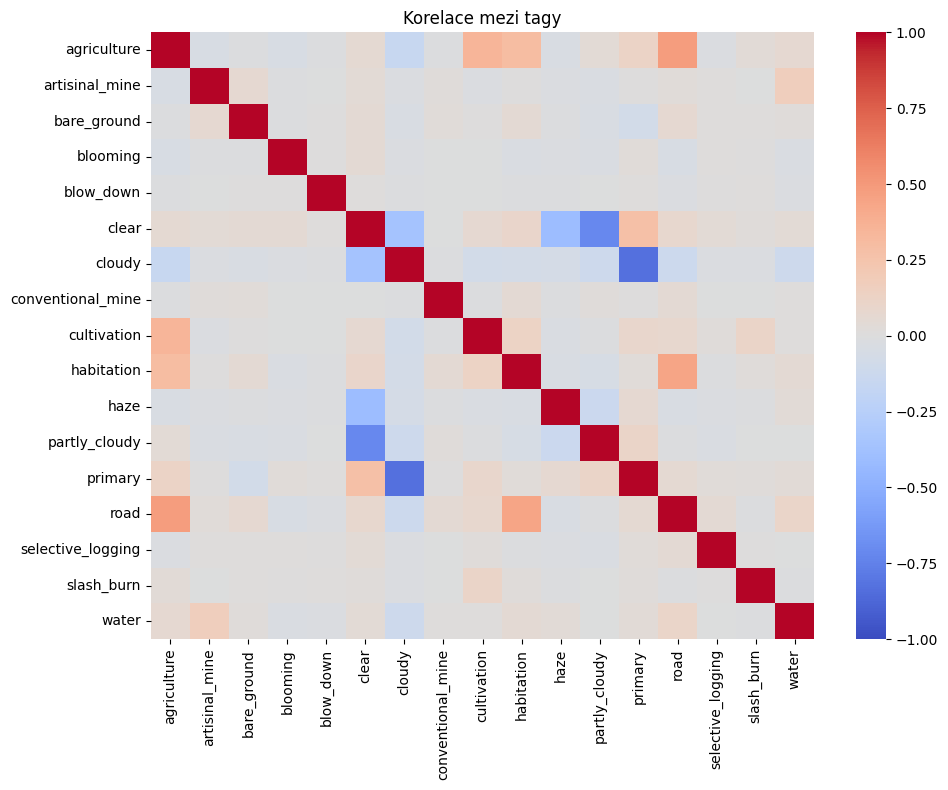

In [54]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"\nPočet trénovacích vzorků: {len(train_data)}")
print(f"Počet validačních vzorků: {len(valid_data)}")
# Vytvoření datasetů
train_dataset = PlanetDataset(train_data, TRAIN_DIR, transform=train_transform)
valid_dataset = PlanetDataset(valid_data, TRAIN_DIR, transform=val_transform)

def visualize_class_correlations(dataset, unique_tags):
    num_tags = len(unique_tags); correlation_matrix = np.zeros((num_tags, num_tags))
    # Sběr všech labelů
    all_labels = []
    for _, label in dataset:
        all_labels.append(label.numpy())
    all_labels = np.array(all_labels)
    # Výpočet korelací mezi tagy
    for i in range(num_tags):
        for j in range(num_tags):
            correlation_matrix[i, j] = np.corrcoef(all_labels[:, i], all_labels[:, j])[0, 1]
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, xticklabels=unique_tags, yticklabels=unique_tags, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
    plt.title('Korelace mezi tagy'); plt.tight_layout(); plt.show()
visualize_class_correlations(train_dataset, unique_tags)


Zde jsem si udělal korelační matici mezi třídami, abych měl přehled v datasetu o některých kritických třídách a jejich výskytu.

#### Načtení dat do DataLoaderu a jejich vizualizace.

Datasety si načtu do DataLoaderu obsahující dávky (iterace) dat pomocí funkce z PyTorch, abych z nich mohl udělat trénovací model, ve kterých si určím batch size, který obvykle bývá 32, jestli je chci zamíchat a počet workerů na kolika vláknech se mi to bude načítat. Vícevláknové načítání může někdy způsobit problém, že se data načítají delší dobu nebo deadlock. A potom si můžu vypsat ukázku načtení jedné dávky dat obrázků a labelů z train DataLoaderu. Tato operace, pokud těch dat je hodně, může už trvat dlouhou dobu. Můžu si vypsat, jak vypadá taková jedna dávka dat připravená pro vytvoření trénovacího modelu pomocí resnet50. Vizualizuji si obrázky z datasetu. Na konci si ještě můžu nastavit hodnoty deformací obrázků pro průměr a smerodatnou odchylku, poté už jsou data připravena pro trénování.


Tvar načtených obrázků: torch.Size([32, 3, 224, 224])
Tvar načtených tagů: torch.Size([32, 17])
Čas pro načtení dat do DataLoaderu:  0.32199811935424805  s


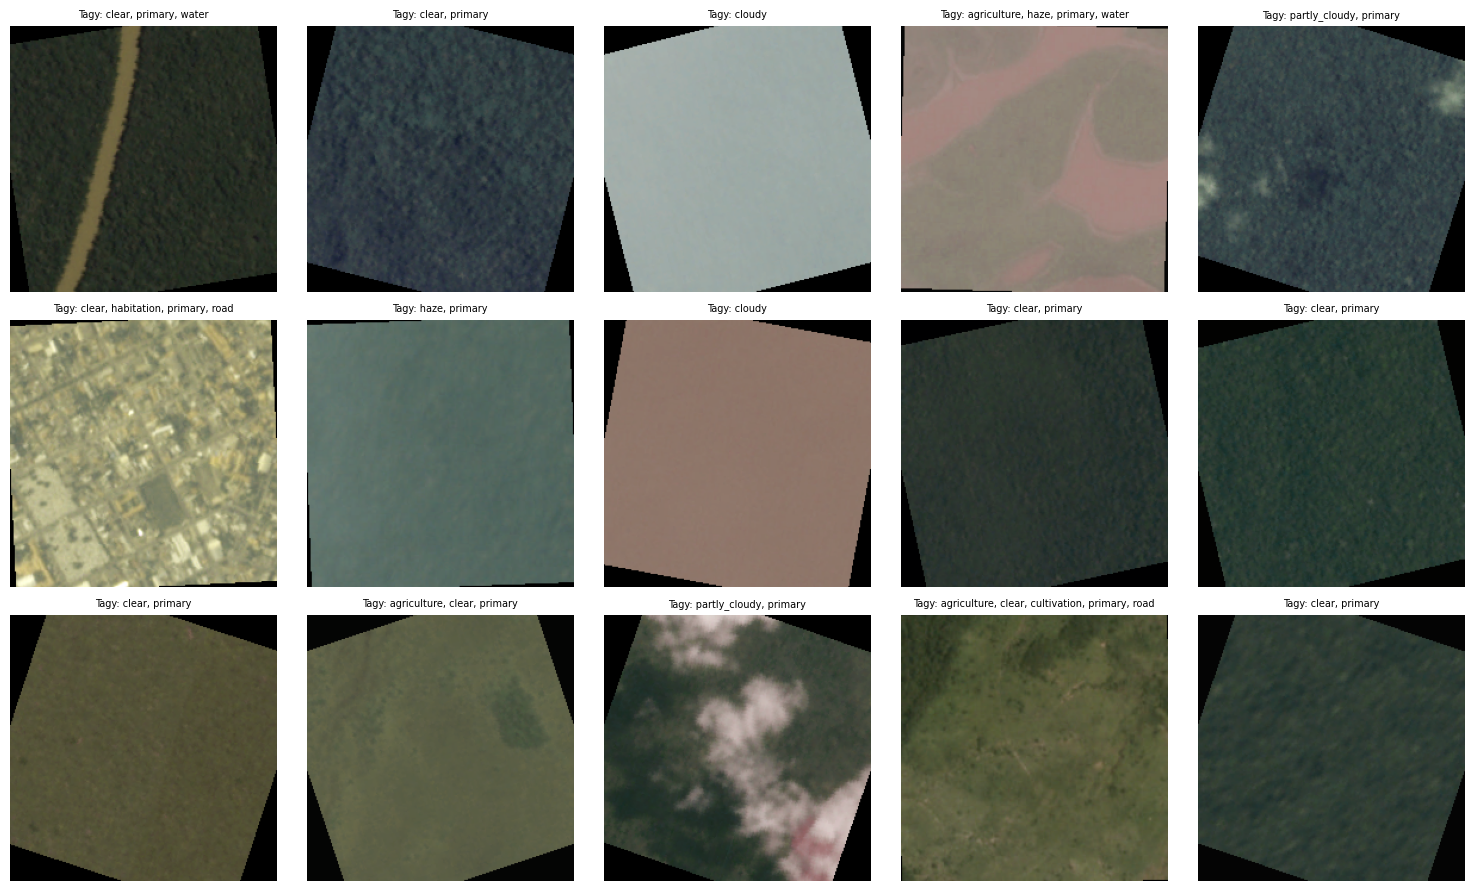


Data jsou připravena pro trénování modelu!


In [55]:
# Vytvoření dataloaderů
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# Ukázka načtení jedné dávky dat
start_time = time.time()
images, labels = next(iter(train_loader))
end_time = time.time()
print(f"\nTvar načtených obrázků: {images.shape}")
print(f"Tvar načtených tagů: {labels.shape}")
print("Čas pro načtení dat do DataLoaderu: ", end_time - start_time, " s")
# Vizualizace několika obrázků z datasetu
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
def visualize_sample(dataset, num_samples=15):
    num_rows = (num_samples + 5 - 1) // 5
    plt.figure(figsize=(15, 3*num_rows))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()
        # Denormalizace obrázku pro zobrazení
        image = std * image + mean
        image = np.clip(image, 0, 1)
        tags = [unique_tags[j] for j in range(len(unique_tags)) if label[j] == 1]
        plt.subplot(num_rows, 5, i+1)
        plt.imshow(image)
        plt.title(f"Tagy: {', '.join(tags)}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_sample(train_dataset)
print("\nData jsou připravena pro trénování modelu!")

#### Použití předtrénovaného modelu
Vytvoříme si třídu multi-label klisifikátoru pro klasifikaci daných dat, aby se mohla trénovat. Klasifikátor bude využívat předtrénovaný model Resnet50. Když jsou data připravená, můžu už začít s předtrénovaným modelem resnet50. Při inicializaci se zavolá metoda super() pro danou třídu a __init__, která umořňuje volat metody definované v nadřazené třídě z podtřídy, což umožňuje rozšiřovat a přizpůsobovat funkcionalitu zděděnou z nadřazené třídy. Nadefinujeme si proměnnou pro model resnet50 s předtrénovanými tady. 

Zmrazí se prvních 10 vrstev. Nahradí finální plně připojenou vrstvu pro multi-label klasifikátor. Nastavíme si sekvenci, v jaký sekvenci chceme, aby nám trénovací model trénoval data. 

Nadefinujem si nejdřív, aplikujme na vstupní data lineární transformaci podle dané rovnice pro plně připojenou vrstvu, kde si určíme počet dimenzí a velikost každého vstupního a každého výstupního vzorku a volitelně se dá nastavit bias boolean, jestli se vestva naučí aditivní zkreslení, defaultně je true. 

Dále ReLU, který aplikuje usměrněnou lineární jednotkovou funkci podle daného vzorce po jednotlivých prvcích, máme inplace bool, podle kterého určíme jestli chceme provést operaci na místě, jeho defaultní hodnota je false. 

Definujeme si jaký chceme Dropout, který během tréování vynuluje některé prvky vstupního tensoru s pranděpodobností p. Vynulované prvky jsou vybírány nezávisle pro každé dopředné volání a vzorkovány z Beurnouliho rozdělení. Každý kanál vynulován nezávisle při dopředném volání. Je to účinná technika pro regularizaci a prevenci koadaptace neuronů. Modul jednoduše vypočítá jednotkovou funkci. Obsahuje parametry p (float) označující P vynulování prvku (výchozí je 0.5) a inplace bool, jestli se tato operace provede na místě (výchozí je false).

Poté tohleto ještě můžeme opakovat ReLu, Dropout a Lineární transformaci, kde si převedem počet vstupních dimenzí na počet tříd.

Ještě máme ve třídě udělanou funkci pro vrácení přední vrstvy klasifikátoru vstupující hodnoty x. 

In [56]:
# vytvoření multi-label klasifikátoru pomocí ResNet50
class PlanetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlanetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Zmrazení prvních 10 vrstev modelu
        for param in list(self.resnet.parameters())[:-10]:
            param.requires_grad = False
        # Nahrazení finální plně připojené vrstvy pro multi-label klasifikaci
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.resnet(x)

#### Vytvoření trénovacího modelu
Vytvoříme si funkci pro trénování modelu, kam nám bude vstupovat náš vytvořený klasifikátor, dataset loader trénovacích dat a dataset loader validačních dat, criterion zaznamenávající ztrátu, optimizer (nejčastější je Adam), scheduler (zaznamenává průběžný learning rate) a epochs (kolik chci provést epoch).

Nejdříve si ve funkci určím device zařízení pro trénování modelu podle toho jestli chci cude (grafickou kartu od Nvidie) a jestli počítač nemá grafiku od Nvidie, tak se může zvolit cpu (procesor).

Teďka je potřeba dosadit do našeho modelu toto zařízení, pomocí kterého se bude učit. Určíme si proměnnou pro zaznamenávání nejlepší hodnoty, podle které si potom na konci uložíme ten nejlepší model. 

Vytvoříme si seznamy pro ztráty tréningových dat a validačních dat, podle kterých poté budeme zobrazovat úspěšnost modelu.

Model budeme učit v epochách (cyklech) tím, že si vytvoříme hlacní for-cyklus pro daný počet epoch, kolik chceme provést. Před dalším for cyklem vypíšeme na kolikáté epoše náš model je.

**1. Trénování dat**
Násleďně pomocí příkazu model.train() začne trénování v dané fázi modelu. Při tomto trénování si budem do proměnné running_loss zaznamenávat ztrátu. For-cyklem projdeme inputy a labely pro loader dataset trénovacích dat, kde je přidáme do device paměti grafické karty nebo procesoru, který je bude učit. U optimizéru si nastavíme zero_grad(), který resetuje gradienty všech optimalizovaných objektů tensoru. Inputy v modelu převedeme na proměnnou outputs a násleďně vytvoříme proměnnou loss, kam uložíme podle kriterion, kam vstupují outputs s labely. Uděláme loss.backward() ztrátových dat, který gradient aktuálního tensoru vzhledem k listům grafu. Dále optimizer.step(), který provede jeden optimalizační krok pro aktualizaci parametru. Poté uložíme do proměnné running_loss ztrátový item vynásobený velikostí inputu.

Potom, když nám tento for-cyklus pro danou ecpochu proběhl můžeme udělat proměnnou epoch_train_loss, do které se uloží procentuální ztráta u každé epochy a tu následně uložíme do train_loses seznamu.

**2.Validace dat**
Teď je potřeba ještě projít validační data v dané fázi, kde začne vyhodnocování modelu pomocí příkazu model.eval() pro validaci dat, u kterého zase budeme zaznamenávat running_loss ztrátu a bude mít seznamy pro ukládání predikátů a labelů. Pomocí PyTorch s vypnutím výpočtu gradientů s for-cyklem, který má inputy a labely pro loader dataset validačních dat provedeme validační fázi, která už je o něco jednodušší než u trénovacích dat. Zase inputy a labely přidáme do daného zařízení, uděláme outputy a vytvoříme loss proměnnou pomocí criterion, running_loss proměnnou, kde se zaznamená aktuální ztráta při validaci. U validačních dat vytvoříme binární predikce pomocí sigmoidy, kam budou vstupovat outputy a nastaví se u toho minimální dolní mez, odkud chceme, aby nám to bralo predikce. Binární predikce ještě převedeme do float formátu a následně je uložíme do seznamu všech predikcí, které nám vrátí z CPU paměti. Do seznamu všech labelů také uložíme labely, které nám také vrátí z CPU paměti.

Predikáty a labely z validačních dat převedeme pomocí torch do 1D dimenze a do formátu Numpy array. Do proměnné epoch_val_loss si uložíme úspěšnost validace.

**Vyhodnocení dané fáze**
Teď, když proběhlo trénování a validace, uděláme nějaké vyhodnocení dané fáze trénovacího modelu.

Z daných dat uděláme precision score a recall score. Vypočítáme F1 score z dané fáze a potom celkové. Násleďně tyto data vypíšeme. Vypíšeme i F1 score pro 5 nejlepších a nejhorších tagů.

Aktualizujem learning rate pomocí schenduler.(Důležité) Nejlepší model uložíme do souboru typu pth. 

**Visualizace výsledků trénovacího modelu**
Nakonec si uděláme graf vizualizace výsledků trénovacího modelu, který si uložíme do souboru a z celé funkce vrátíme vytrénovaný model.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Používám zařízení: {device}")
    model = model.to(device)
    best_val_f1 = 0.0
    train_losses = []; val_losses = []; train_accuracies = []; val_accuracies = []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        model.train()
        running_loss = 0.0; correct = 0.0; total = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100.0 * correct / total
        train_accuracies.append(train_accuracy)

        model.eval()
        running_loss = 0.0; correct = 0.0; total = 0.0
        all_preds = []; all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        all_preds = torch.cat(all_preds, dim=0).numpy()
        all_labels = torch.cat(all_labels, dim=0).numpy()
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100.0 * correct / total
        val_accuracies.append(val_accuracy)
        # Výpočet metrik
        precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
        sample_f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
        macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        print(f'Train Loss: {epoch_train_loss:.4f}%, Val Loss: {epoch_val_loss:.4f}%, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
        print(f'Precision: {precision:.4f}%, Real Precision(Recall): {recall:.4f}%')
        print(f'Sample F1(Harmonic mean): {sample_f1:.4f}, Macro F1(Score for every class): {macro_f1:.4f}')
        tag_f1_scores = []
        for i, tag in enumerate(unique_tags):
            tag_f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
            tag_f1_scores.append((tag, tag_f1))
        tag_f1_scores.sort(key=lambda x: x[1], reverse=True)
        print("\nF1 skóre pro nejlepší tagy:")
        for tag, f1 in tag_f1_scores[:5]:
            print(f"{tag}: {f1:.4f}")
        print("\nF1 skóre pro nejhorší tagy:")
        for tag, f1 in tag_f1_scores[-10:]:
            print(f"{tag}: {f1:.4f}")
        # Aktualizace learning rate
        scheduler.step(epoch_val_loss)

        if sample_f1 > best_val_f1:
            best_val_f1 = sample_f1
            torch.save(model.state_dict(), 'best_planet_classifier.pth')
            print("Uložen nejlepší model!")
    # Vizualizace výsledků tréninku
    plt.figure(figsize=(12, 5))
    #Graf ztráty (loss)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Trénovací ztráta')
    plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validační ztráta')
    plt.xlabel('Epocha'); plt.ylabel('Ztráta (v %)'); plt.title('Trénovací a validační ztráta')
    plt.grid(True)
    plt.legend()
    # Graf přesnosti (accuracy)
    plt.subplot(2, 1, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, 'g-', label='Trénovací přesnost')
    plt.plot(range(1, num_epochs+1), val_accuracies, 'm-', label='Validační přesnost')
    plt.xlabel('Epocha'); plt.ylabel('Přesnost (v %)'); plt.title('Trénovací a validační přesnost')
    plt.grid(True)
    plt.legend()
    plt.tight_layout(); plt.savefig('training_results.png', dpi=300, bbox_inches='tight'); plt.show()
    return model

### Trénování modelu
Nyní provedeme trénování modelu. Uděláme model z vytvořené vlastní třídy klasifikátoru, kam nám vstupuje počet tříd roven počtu unikátních tagů v trénovacím datasetu, které zároven indkují, že se jedná o multi-label klasifikaci. 

Určíme si criterion pro ztrátová data. BCEWithLogitsLoss(), tato ztráta kombinuje vrstvu sigmoidy a BCELoss do jedné třídy a zároveň je ideální pro multi-label klasifikaci, kde jeden snímek může obsahovat více prvků najednou. Tato verze ztráty je numericky stabilnější než použití prosté sigmoidy, protože kombinací operací do jedné vrstvy využívá trik logaritmického součtu a explorace pro numerickou stabilitu. U této ztráty si můžeme určit reduction (Redukci, která se má použít na výstup: mean, sum nebo none), může sem vstupovat pos_weight (Volitelný tensor, kam vstupují prvky torch.ones([num_classes]) odpovídající odlišným třídám ve scénáři binární klasifikace s více štítky. Každý prvek v pos_weight je navržen tak, aby upravoval funkci ztrát na základě nerovnováhy mezi negativními a pozitivními vzorky pro příslušnou třídu. Tento přístup je užitečný v datasetech s různou úrovní nerovnováhy tříd.), weight (Tensor, volitelný parametr pro ruční váhu pro změnu škalování přiřazené ztrátě každého prvku batche), size_average (Bool, volitelný, zastaralé. V jeho výchozím nastavení se ztráty průměrují nebo sčítají pro každou dávku v závislosti na size_average) a pos_weight (Volitelný tensor, kde se určí váha positivních příkadů, které se májí vysílat s cílem)

Určíme si optimizer, přes který implementujeme optimalizační algoritmus, vytvoříme objekt, který bude uchovávat aktuální stav a aktualizovat parametry na základě vypočítaných parametrů. Nejčastěji se používá Adam, který upravuje learning rate pro každý parametr zvlášť a u kterého se dá nastavit spousta volitelných vlastností, jako je params (iterovatelný objekt parametrů), lr (Float a tensor. Rychlost učení), betas (Koeficienty použité pro výpočet klouzavých průměrů gradientu a jeho druhé mocniny.), eps (Float člen přidaný do jmenovatele pro zlepšení num stability.), weight_decay (Float úbytku hmotnosti), decoupled_weight_decay (Bool jestli má algoritmus akumulovat úbytek hmotnosti v hybnosti nebo rozptylu.), amsgrad (Zda použít variantu AMSGrad algoritmu.), foreach(Bool), maximize (Jestli chceme maximalizovat cíl s ohledem na parametry, místo minimalizace), atd... Vstupuje do něj filtr, který pouze vybírá parametry modelu, které mají povolený gradient. Toto nastavení umožňuje rychlé učení na začátku tréninku a jemnější doladění, když se model přibližuje k optimu, což je zvláště důležité pro detailní klasifikaci geografických prvků.

Schenduler ReduceLROnPlateau(), který nám snižuje learning rate, když se validační ztráta přestane zlepšovat. Pro geografická data, kde může být obtížné najít optimální learning rate, je toto adaptivní přizpůsobení velmi užitečné. Má nastavené parametry min (Sleduje minimální metriky, validační loss), patience (Čeká daný počet epoch bez zlepšení, než se sníží learning rate), factor (Při aktivaci sníží learning rate na polovinu (0.5*současná hodnota).)

Násleně všechny tyto proměnné dáme do funkce train model, která ám ho vytrénuje. Do funkce vstupuje: klasifikátor modelu, daný loader trénovacích dat, loader validačních dat, criterion pro ztrátová data, optimizer, scheduler a nastavený počet fází (epoch) v kolika to chceme provést.

c:\Users\imang\OneDrive\Plocha\USU\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\imang\OneDrive\Plocha\USU\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trénování modelu...
Používám zařízení: cpu

Epoch 1/15
----------------------------------------
Train Loss: 0.1576, Val Loss: 0.1228
Precision: 0.9029, Recall: 0.8574
Sample F1: 0.8695, Macro F1: 0.4318

F1 skóre pro nejlepší tagy:
primary: 0.9802
clear: 0.9498
partly_cloudy: 0.8339
cloudy: 0.8067
agriculture: 0.7699

F1 skóre pro nejhorší tagy:
blooming: 0.0000
blow_down: 0.0000
conventional_mine: 0.0000
selective_logging: 0.0000
slash_burn: 0.0000
Uložen nejlepší model!

Epoch 2/15
----------------------------------------
Train Loss: 0.1367, Val Loss: 0.1193
Precision: 0.9106, Recall: 0.8598
Sample F1: 0.8752, Macro F1: 0.4678

F1 skóre pro nejlepší tagy:
primary: 0.9804
clear: 0.9475
partly_cloudy: 0.8182
cloudy: 0.8134
agriculture: 0.7661

F1 skóre pro nejhorší tagy:
blooming: 0.0000
blow_down: 0.0000
conventional_mine: 0.0000
selective_logging: 0.0000
slash_burn: 0.0000
Uložen nejlepší model!

Epoch 3/15
----------------------------------------
Train Loss: 0.1303, Val Loss: 0.1155

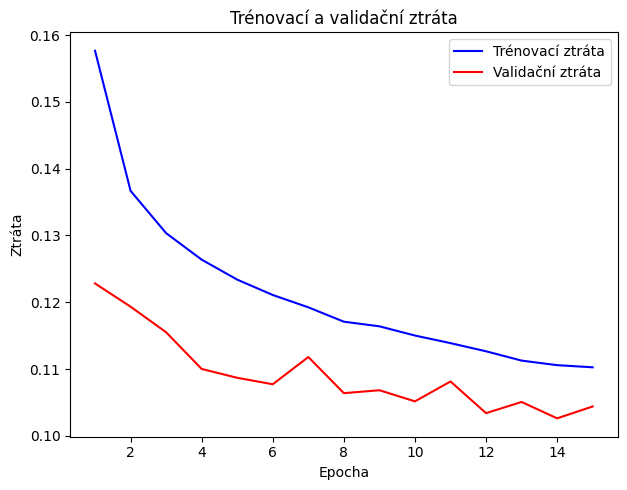

In [58]:
# Inicializace modelu, kritéria, optimizéru a scheduleru
model = PlanetClassifier(num_classes=len(unique_tags))
criterion = nn.BCEWithLogitsLoss()  # Vhodné pro multi-label klasifikaci
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

print("Trénování modelu...")
num_epochs = 15
start_time = time.time()
trained_model = train_model(model=model, train_loader=train_loader, val_loader=valid_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=num_epochs)
end_time = time.time()
print(f"Čas pro vytrénování modelu v {num_epochs} epochách: ", (end_time - start_time)/60, " minut, ", (end_time - start_time)/60/60, " hodin")


První tréning mi trval celkově skoro 29 hodin, když odečtu přibližně polovinu, co jsem měl notebook v hibernaci, tak to bylo 15 hodin. Při prvním tréningu jsem dosáhl přibližně 89% u trénovacích dat a přibližně 89.5% u validačních dat. Viz křivka, kde je zobrazený průběh tréningu v jednotlivých etapách, kde u validačních dat to bylo proměnlivé. Při prvním tréningu jsem narazil na problém, že některé třídy mají pořád 0 F1 skóre, takže není možné, aby je strojové učení detekovalo, i když v průběhu některé nulové tagy dostali svoje F1 skóre. Zřejmě by tady nebylo za špatné zvýšit některým kritikým hodnotám v datasetu, co se tam tolik nevyskytují pravděpodobnosti, aby je bylo schopno strojové učení detekovat.

### Vyhodnocení nejlepšího modelu
Načteme si ten nejlepší model.

In [59]:
model.load_state_dict(torch.load('best_planet_classifier.pth'))

<All keys matched successfully>

#### Testování modelu na testovacíhch datech
Funkce pro predikci a vytvoření submission souboru pro testovací data na nejlepším modelu.

In [85]:
def create_submission(model, test_loader, submission_df, max_samples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    predictions = []; image_names = []; processed_samples = 0
    with torch.no_grad():
        for batch, (inputs, _) in enumerate(test_loader):
            if processed_samples >=max_samples: break
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().cpu().numpy()
            for i in range(len(preds)):
                idx = batch * test_loader.batch_size + i
                if idx < len(submission_df) and processed_samples < max_samples:
                    img_name = submission_df.iloc[idx]['image_name']
                    image_names.append(img_name)
                    # Získání tagů pro predikci
                    pred_tags = []
                    for j, val in enumerate(preds[i]):
                        if val == 1:
                            pred_tags.append(unique_tags[j])
                    predictions.append(' '.join(pred_tags))
                    processed_samples += 1
    print(f"Zpracováno {processed_samples} vzorků.")
    # Vytvoření submission dataframe
    submit_df = pd.DataFrame({'image_name': image_names, 'tags': predictions })
    # Uložení do CSV
    submit_df.to_csv('submission.csv', index=False)
    print("Submission soubor byl vytvořen!")

#načtení testovacího datasetu
filtered_submission_df = submission_df.head(10000)
filtered_submission_df['tag_vector'] = [np.zeros(len(unique_tags)) for _ in range(len(filtered_submission_df))]
test_dataset = PlanetDataset(filtered_submission_df, TRAIN_DIR, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

start_time = time.time()
create_submission(trained_model, valid_loader, submission_df=submission_df, max_samples=10000)
end_time = time.time()
print(f"Čas pro vytvoření submission na testovacích datech.: ", (end_time - start_time)/60, " minut, ", (end_time - start_time)/60/60, " hodin")


C:\Users\imang\AppData\Local\Temp\ipykernel_23396\1315501542.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_submission_df['tag_vector'] = [np.zeros(len(unique_tags)) for _ in range(len(filtered_submission_df))]


Zpracováno 8096 vzorků.
Submission soubor byl vytvořen!
Čas pro vytvoření submission na testovacích datech.:  8.268110803763072  minut,  0.13780184672938453  hodin


#### Confusion matrices
Vyhodnocení nejlepšího modelu pomocí confusion matrices.

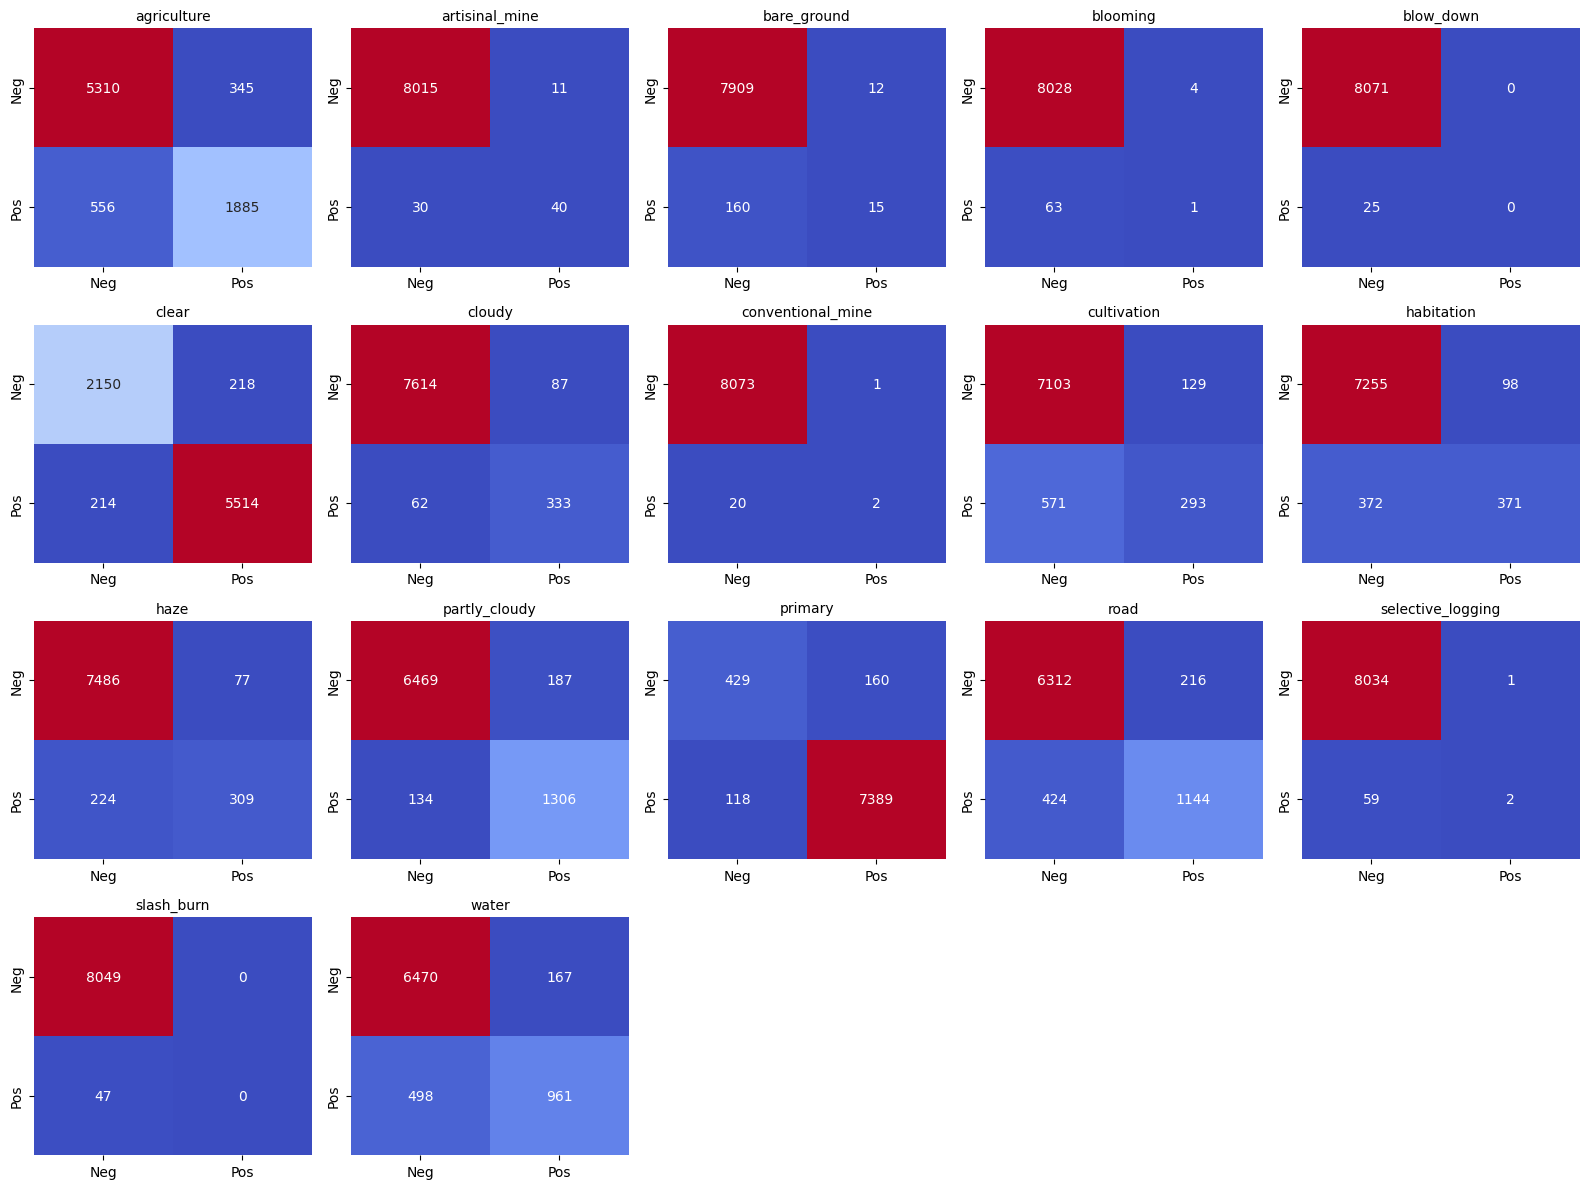

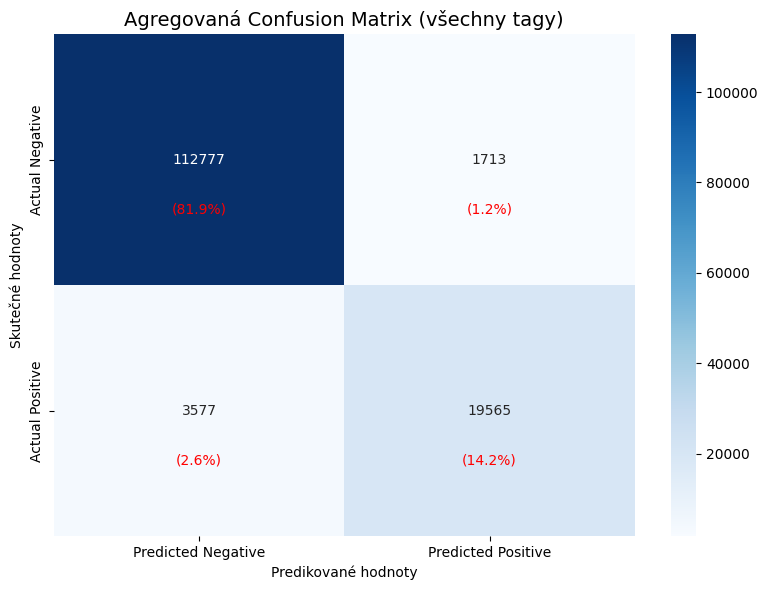


DETAILNÍ PŘEHLED VÝSLEDKŮ PRO VŠECHNY TAGY
Rank Tag                  Precision  Recall   F1-Score  Support 
----------------------------------------------------------------------
1    primary              0.979      0.984    0.982     7507    
2    clear                0.962      0.963    0.962     5728    
3    partly_cloudy        0.875      0.907    0.891     1440    
4    cloudy               0.793      0.843    0.817     395     
5    agriculture          0.845      0.772    0.807     2441    
6    road                 0.841      0.730    0.781     1568    
7    water                0.852      0.659    0.743     1459    
8    haze                 0.801      0.580    0.672     533     
9    artisinal_mine       0.784      0.571    0.661     70      
10   habitation           0.791      0.499    0.612     743     
11   cultivation          0.694      0.339    0.456     864     
12   conventional_mine    0.667      0.091    0.160     22      
13   bare_ground          0.556      0.0

In [92]:
def evaluate_model_with_confusion_matrix(model, data_loader, unique_tags):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    all_preds = []; all_labels = []; processed_samples = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    # Spojení všech dávek
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # GRID LAYOUT - Všechny tagy v jednom obrázku
    n_tags = len(unique_tags)
    n_cols = 5  # Počet sloupců v gridu
    n_rows = (n_tags + n_cols - 1) // n_cols  # Výpočet počtu řádků
    plt.figure(figsize=(16, 3 * n_rows))
    binary_cm = multilabel_confusion_matrix(all_labels, all_preds)
    for i in range(n_tags):
        plt.subplot(n_rows, n_cols, i + 1)
        cm = binary_cm[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'], cbar=False)
        plt.title(f'{unique_tags[i]}', fontsize=10)
        plt.xlabel('')
        plt.ylabel('')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout(); plt.savefig('all_tags_confusion_matrix_grid.png', dpi=300, bbox_inches='tight'); plt.show(); plt.close()
    # KOMPAKTNÍ CONFUSION MATRIX - Agregované hodnoty
    # Výpočet agregovaných hodnot
    total_tp = np.sum([binary_cm[i][1,1] for i in range(n_tags)])
    total_fp = np.sum([binary_cm[i][0,1] for i in range(n_tags)])
    total_fn = np.sum([binary_cm[i][1,0] for i in range(n_tags)])
    total_tn = np.sum([binary_cm[i][0,0] for i in range(n_tags)])
    # Vytvoření agregované confusion matrix
    aggregated_cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(aggregated_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Agregovaná Confusion Matrix (všechny tagy)', fontsize=14); plt.ylabel('Skutečné hodnoty'); plt.xlabel('Predikované hodnoty')
    # Přidání procent
    total = np.sum(aggregated_cm)
    for i in range(2):
        for j in range(2):
            percentage = (aggregated_cm[i,j] / total) * 100
            plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', ha='center', va='center', fontsize=10, color='red')
    plt.tight_layout(); plt.savefig('aggregated_confusion_matrix.png', dpi=300, bbox_inches='tight'); plt.show(); plt.close()
    # 5. INTERAKTIVNÍ TABULKA S DETAILY
    print("\n" + "="*80)
    print("DETAILNÍ PŘEHLED VÝSLEDKŮ PRO VŠECHNY TAGY")
    print("="*80)

    precisions = []; recalls = []; f1_scores = []; supports = []
    for i in range(n_tags):
        cm = binary_cm[i]
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = tp + fn
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        supports.append(support)
    metrics_df = pd.DataFrame({'Tag': unique_tags, 'Precision': precisions, 'Recall': recalls, 'F1-Score': f1_scores, 'Support': supports})
    metrics_df_sorted = metrics_df.sort_values('F1-Score', ascending=False)
    print(f"{'Rank':<4} {'Tag':<20} {'Precision':<10} {'Recall':<8} {'F1-Score':<9} {'Support':<8}")
    print("-" * 70)
    for idx, (_, row) in enumerate(metrics_df_sorted.iterrows()):
        print(f"{idx+1:<4} {row['Tag']:<20} {row['Precision']:<10.3f} {row['Recall']:<8.3f} {row['F1-Score']:<9.3f} {row['Support']:<8.0f}")
    # Celkové statistiky
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    print("\n" + "="*50)
    print("CELKOVÉ STATISTIKY")
    print("="*50)
    print(f"Průměrná Precision: {avg_precision:.4f}")
    print(f"Průměrný Recall:    {avg_recall:.4f}")
    print(f"Průměrný F1 Score:  {avg_f1:.4f}")
    print(f"Celkový počet tagů: {len(unique_tags)}")
    return metrics_df_sorted

start_time = time.time()
df_metrics = evaluate_model_with_confusion_matrix(trained_model, valid_loader, unique_tags)
end_time = time.time()
print(f"Čas pro vytvoření confusion matrices na testovacích datech.: ", (end_time - start_time)/60, " minut, ", (end_time - start_time)/60/60, " hodin")
